In [1]:
using JuMP
using CPLEX
using Distributions
using LinearAlgebra
using Statistics
using Dates
using DataFrames
using SDDP
using Plots
import CSV
using JSON
try
    using Revise
catch e
    @warn "Error initializing Revise" exception=(e, catch_backtrace())
end

In [25]:
includet(dirname(pwd()) * "\\Water_Regulation\\WaterRegulation.jl")
using .WaterRegulation

### General Parameters

In [48]:
filepath_Ljungan = dirname(pwd()) * "\\Water_Regulation\\TestDataWaterRegulation\\Ljungan.json"
filepath_prices = dirname(pwd()) *  "\\Data\\Spot Prices\\prices_df.csv"
filepath_results = dirname(pwd()) * "\\Results\\LambdaZero\\"
all_res, plants, parts = read_data(filepath_Ljungan)
print() 

### River System  
We will work with Sydkraft in this example  
For ease at first we have one producer, one reservoir and one plant.

In [49]:
j = parts[1]
pj = j.participationrate
res = filter(r -> j.participationrate[r] > 0, all_res)[1]
k = j.plants[1]

println("Participant: ", j)
println("Reservoir: ", res)
println("Power Plant: ", k)

Participant: Sydkraft


Reservoir: Flasjon
Power Plant: Flasjo


### Bidding Model  
At the Electricity Markets, Participants have to communicate increasing bidding curves of price-volume pairs before market clearing.  
Depending on the market clearing price, the delivery of each participant becomes known  
We approximate this relation by using linear interpolation of volumes and presetting price Points, for example based on probabilities.

$$
y_t = \frac{c_t - P_{t,i} }{P_{t,i+1} - P_{t,i}} \cdot x_{i,t} + \frac{P_{t,i+1} - c_t }{P_{t,i+1} - P{t,i}} \cdot x_{i+1,t}, \qquad \text{if} \qquad P_{t,i} \leq c_t \leq P_{t,i+1}
$$

The Volumes have to be in increasing order:

$$
x_{i,t} \leq x_{i+1,t}
$$

### Hydro Model

The Commodity we deal with is electricity. At all times it has to be in balance and consumed at the moment it is generated. The means of producing electricity is a pure hydro system with a reservoir upstream for storage.  

$$
\begin{align*}
l &= \text{Reservoir level} \\
Q &= \text{Flow of Water} \\
w &= \text{Electrical Production} \\
e &= \text{Equivalent}
\end{align*}
$$

### Set Parameters necessary for Input into Model

In [50]:
const Stages = 8 # 2 lowest number as first stage is just to achieve nonanticipativity
const T = 24
PPoints = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
I = length(PPoints)-1

println("Stages :" , Stages, "\n Hours: ", T, "\n I : ", I, "\n Price Points = ", [i for i in PPoints])

Qref = Dict{Reservoir, Float64}(r => 10.0 for r in [res])
scenario_count = 3
Prices = [floor.(rand(T), sigdigits=3) for i in 1:scenario_count]
Inflows = [10.0]
Omega = [(price = p, inflow = v) for p in Prices for v in Inflows]
P = [1/length(Omega) for om in Omega]
# StartUp Costs
const S = 0.1
# Cost for Up and Down Balancing
const mu_up = 0.7
const mu_down = 0.3

println("Uncertainty Set: ", Omega)

Stages :8
 Hours: 24
 I : 5
 Price Points = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


Uncertainty Set: NamedTuple{(:price, :inflow), Tuple{Vector{Float64}, Float64}}

[(price = [0.961, 0.934, 0.872, 0.672, 0.969, 0.585, 0.691, 0.542, 0.116, 0.462, 0.0692, 0.875, 0.791, 0.183, 0.0402, 0.115, 0.349, 0.0174, 0.507, 0.244, 0.78, 0.489, 0.969, 0.532], inflow = 10.0), (price = [0.0836, 0.945, 0.553, 0.348, 0.252, 0.815, 0.38, 0.975, 0.0867, 0.854, 0.302, 0.758, 0.906, 0.577, 0.897, 0.738, 0.0122, 0.497, 0.669, 0.832, 0.68, 0.479, 0.0622, 0.989], inflow = 10.0), (price = [0.47, 0.538, 0.355, 0.339, 0.922, 0.336, 0.767, 0.216, 0.82, 0.0315, 0.213, 0.629, 0.627, 0.66, 0.819, 0.287, 0.272, 0.73, 0.92, 0.841, 0.808, 0.0403, 0.576, 0.888], inflow = 10.0)]


### Definition of Subproblems

In [51]:
function subproblem_builder(subproblem::Model, node::Int64)
    @variable(subproblem, 0 <= x[i = 1:I+1, t = 1:T] <= 50, SDDP.State, initial_value=0)
    @variable(subproblem, 0 <= l <= res.maxvolume, SDDP.State, initial_value = res.currentvolume)
    @variable(subproblem, y[t=1:T] >= 0)
    @variable(subproblem, w[t=1:T] >= 0)
    @variable(subproblem, b[t=1:T] >= 0)
    @variable(subproblem, Q[t=1:T] >= 0)
    @variable(subproblem, f >= 0)
    @variable(subproblem, s >= 0)

    @constraint(subproblem, clearing[t=1:T], y[t] == sum(1* x[i,t].in +  1* x[i+1,t].in for i in 1:I))
    @constraint(subproblem, increasing[i = 1:I, t=1:T], x[i,t].out <= x[i+1,t].out)
    if node == 1
        @stageobjective(subproblem, 0)
        @constraint(subproblem, balance_transfer, l.in == l.out)
    else
        @constraint(subproblem, obligation[t=1:T], y[t] == w[t] + b[t])
        @constraint(subproblem, balance, l.out == l.in - sum(Q[t] for t in 1:T)/T + T - s)
        @constraint(subproblem, production[t=1:T], w[t] == Q[t] * k.equivalent)
        SDDP.parameterize(subproblem, Omega, P) do om
            JuMP.fix(f, om.inflow, force=true)
            # Define Set of active variables for each hour
            I_t = Dict(t => 0 for t in 1:T)
            for t in 1:T
                for i in 1:I
                    if (om.price[t] >= PPoints[i]) && (om.price[t] <= PPoints[i+1])
                        I_t[t] = i
                    end
                end
            end
            # Include only active variables in stageobjective
            @stageobjective(subproblem ,sum(om.price[t] * y[t] -  mu_up * b[t] for t in 1:T))
            # Fix / Deactivate constraints by setting their coefficients to appropriate values or all zero.
            for t in 1:T
                for i in 1:I
                    if (i == I_t[t])
                        set_normalized_coefficient(clearing[t], x[i,t].in, -((om.price[t] - PPoints[i])/(PPoints[i+1] - PPoints[i])))
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, -((PPoints[i+1] - om.price[t])/(PPoints[i+1] - PPoints[i])))
                    else
                        set_normalized_coefficient(clearing[t], x[i,t].in, 0)
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, 0)
                    end
                end
            end
        end
    end
    return
end

subproblem_builder (generic function with 1 method)

### Build the SDDP Model

In [52]:
model = SDDP.LinearPolicyGraph(
    subproblem_builder;
    stages = Stages,
    sense = :Max,
    upper_bound = 1e5,
    optimizer = CPLEX.Optimizer
)

A policy graph with 8 nodes.
 Node indices: 1, 2, 3, 4, 5, 6, 7, 8


### Train the model

In [53]:
SDDP.train(model; iteration_limit = 100)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------


problem
  nodes           : 8
  state variables : 145
  scenarios       : 2.18700e+03
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : 

SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [389, 389]
  AffExpr in MOI.EqualTo{Float64}         : [25, 73]
  AffExpr in MOI.LessThan{Float64}        : [120, 120]
  VariableRef in MOI.GreaterThan{Float64} : [243, 244]
  VariableRef in MOI.LessThan{Float64}    : [146, 146]


numerical stability report
  matrix range     [4e-02, 2e+00]
  objective range  [1e-02, 1e+00]
  bounds range     [5e+01, 1e+05]
  rhs range        [2e+01, 2e+01]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   1.424102e+03  2.135781e+04  6.128000e+00        30   1


         2   1.019729e+03  3.594031e+03  7.584000e+00       860   1


┌ Warning: Found a cut with a mix of small and large coefficients.
│     The order of magnitude difference is 12.479114511996288.
│     The smallest cofficient is -1.5276668818842154e-13.
│     The largest coefficient is 0.4604083333333333.
│ 
│ You can ignore this warning, but it may be an indication of numerical issues.
│ 
│ Consider rescaling your model by using different units, e.g, kilometers instead
│ of meters. You should also consider reducing the accuracy of your input data (if
│ you haven't already). For example, it probably doesn't make sense to measure the
│ inflow into a reservoir to 10 decimal places.
└ @ SDDP C:\Users\lenna\.julia\packages\SDDP\1uYYz\src\plugins\bellman_functions.jl:68


        21   3.682997e+03  3.594031e+03  8.886000e+00      2230   1


        40   3.540718e+03  3.594031e+03  9.379000e+00      2800   1
-------------------------------------------------------------------
status         : simulation_stopping
total time (s) : 9.379000e+00
total solves   : 2800
best bound     :  3.594031e+03
simulation ci  :  3.452016e+03 ± 1.730759e+02
numeric issues : 0
-------------------------------------------------------------------



### Obtain the Bidding and Nomination Decisions

In [54]:
rule = SDDP.DecisionRule(model; node = 1)
solution = SDDP.evaluate(
    rule;
    incoming_state = Dict(:l => res.currentvolume),
    #incoming_state = merge(Dict(Symbol("l_real[$(r)]") => r.currentvolume for r in res), Dict(Symbol("l_ind[$(r)]") => r.currentvolume for r in res)),
    controls_to_record = [:Q, :y, :x, :l]
)
println(solution.controls[:x])
print(solution.controls[:l])

SDDP.State{Float64}[SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.

}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 

In [55]:
simulations = SDDP.simulate(
    # The trained model to simulate.
    model,
    # The number of replications.
    100,
    # A list of names to record the values of.
    [:x, :y, :w, :l, :b, :Q, :f],
)

100-element Vector{Vector{Dict{Symbol, Any}}}:
 [Dict(:b => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], :l => SDDP.State{Float64}(3674.0, 3674.0), :w => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], :bellman_term => 3594.0305974999983, :node_index => 1, :objective_state => nothing, :belief => Dict(1 => 1.0), :x => SDDP.State{Float64}[SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0); … ; SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0)], :stage_objective => 0, :Q => [0.0, 

In [56]:
replication = 28
stage = 8
println("Bidding Curve Values: ", simulations[replication][stage][:x])
println("Cleared Volume: ", simulations[replication][stage][:y])
println("Reservoir Level: ", simulations[replication][stage][:l])
println("Own Production: ", simulations[replication][stage][:w])
println("Water Used: ", simulations[replication][stage][:Q])
println("Purchases: ", simulations[replication][stage][:b])
println("Filling in that stage: ", simulations[replication][stage][:f])

Bidding Curve Values: SDDP.State{Float64}[SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(0.0, 0.0); SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State{Float64}(50.0, 0.0) SDDP.State

Reservoir Level: SDDP.State{Float64}(86.13776881720406, 13.135080645161073)
Own Production: [17.49999999999999, 34.50000000000001, 38.74999999999999, 34.75, 50.0, 34.0, 41.74999999999999, 3.9999999999999964, 50.0, 7.875, 3.249999999999996, 7.2500000000000036, 6.7500000000000036, 15.000000000000007, 50.0, 21.749999999999993, 18.000000000000004, 32.49999999999999, 50.0, 50.00000000000001, 50.0, 10.075000000000001, 43.99999999999999, 50.0]
Water Used: [56.45161290322578, 111.2903225806452, 124.99999999999999, 112.0967741935484, 161.29032258064518, 109.67741935483872, 134.6774193548387, 12.903225806451603, 161.29032258064518, 25.403225806451616, 10.483870967741924, 23.387096774193562, 21.77419354838711, 48.38709677419357, 161.29032258064518, 70.16129032258063, 58.06451612903227, 104.83870967741935, 161.29032258064518, 161.2903225806452, 161.29032258064518, 32.50000000000001, 141.93548387096774, 161.29032258064518]
Purchases: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

### Inclusion of Water Regulation Rules

The Water Regulation Rules have to be accounted for when bidding at the Market

* We communicate a sequence of bids at the electricity markets for every hour of the day
* The Water Regulation company receives ONE Bid for discharge over the entire day

For currrent purposes, we assume that the nomination is fixed and can't be changed, and the amount of water has to actually be used over the course of the day.  

* We have to buy electricity on the market for certain hours if our nomination was too low
* We have to sell surplus of water if our nomination was too high. The price on the balancing market is by assumption very low

For that we include an additional State Variable: $Q^\text{nom}_r$ for every reservoir. Let $Q_{r,t}$ the real flow of water from $r$ at hour $t$.   
For every reservoir it has to hold that:  

$$
T \cdot Q^\text{nom}_r = \sum\limits_{t=1}^T Q_{r,t}
$$

We change the objective Function to the following:


$$
\max \; \rightarrow \; \sum\limits_{t = 1}^T y_{i_t, t} \cdot c_t - (\mu^+ \cdot z^+_{i_t,t}  - \mu^- \cdot z^-_{i_t,t})
$$
The coefficient $\mu^+, \mu^-$ are chosen so that they are higher than the highest or lower than the lowest observed spot market price respectively. 
Accordingly, the delivery obligation constraint is changed to (assuming there is one river and one power plant): 

$$
y_{i_t, t} = Q_{r,t} \cdot e_k + z^+_{t} - z^-_{t}  
$$

The difficulty in the agents decision is that the nomination $Q^\text{nom}_r$ has to be done before market clearing, thus it is modelled as a state variable.

In [57]:
function subproblem_builder_regulation(subproblem::Model, node::Int64)
    @variable(subproblem, 0 <= x[i = 1:I+1, t = 1:T] <= 50, SDDP.State, initial_value=0)
    @variable(subproblem, 0 <= l <= res.maxvolume, SDDP.State, initial_value = 1000)
    @variable(subproblem, 0 <= Qnom, SDDP.State, initial_value = 0)
    @variable(subproblem, y[t=1:T] >= 0)
    @variable(subproblem, w[t=1:T] >= 0)
    @variable(subproblem, z_up[t=1:T] >= 0)
    @variable(subproblem, z_down[t=1:T] >= 0)
    @variable(subproblem, Q[t=1:T] >= 0)
    @variable(subproblem, f >= 0)
    @variable(subproblem, s >= 0)

    @constraint(subproblem, clearing[t=1:T], y[t] == sum(1* x[i,t].in +  1* x[i+1,t].in for i in 1:I))
    @constraint(subproblem, increasing[i = 1:I, t=1:T], x[i,t].out <= x[i+1,t].out)
    if node == 1
        @stageobjective(subproblem, 0)
        @constraint(subproblem, balance_transfer, l.out == l.in - Qnom.out - s) 
    else
        @constraint(subproblem, nomination, sum(Q[t] for t in 1:T) == T * Qnom.in)
        @constraint(subproblem, obligation[t=1:T], y[t] == w[t] + z_up[t] - z_down[t])
        @constraint(subproblem, balance, l.out == l.in - T * Qnom.out + f * T - s)
        @constraint(subproblem, production[t=1:T], w[t] == Q[t] * k.equivalent)
        SDDP.parameterize(subproblem, Omega, P) do om
            # We have to make sure that depending on the market clearing price, the coefficients are set accordingly.
            # The recourse action only applies to the real delivery, determined by the uncertain price. The other restricitions become inactive, else they make the problem infeasible.
            # The constraints that are relevant are maiintained in Scenario_Index for every current time step.
            JuMP.fix(f, om.inflow, force=true)
            # Define Set of active variables for each hour
            I_t = Dict(t => 0 for t in 1:T)
            for t in 1:T
                for i in 1:I
                    if (om.price[t] >= PPoints[i]) && (om.price[t] <= PPoints[i+1])
                        I_t[t] = i
                    end
                end
            end
            # Include only active variables in stageobjective
            @stageobjective(subproblem ,sum(om.price[t] * y[t] -  mu_up * z_up[t] + mu_down * z_down[t] for t in 1:T))
            # Fix / Deactivate constraints by setting their coefficients to appropriate values or all zero.
            for t in 1:T
                for i in 1:I
                    if (i == I_t[t])
                        set_normalized_coefficient(clearing[t], x[i,t].in, -((om.price[t] - PPoints[i])/(PPoints[i+1] - PPoints[i])))
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, -((PPoints[i+1] - om.price[t])/(PPoints[i+1] - PPoints[i])))
                    else
                        set_normalized_coefficient(clearing[t], x[i,t].in, 0)
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, 0)
                    end
                end
            end
        end
    end
    return
end

subproblem_builder_regulation (generic function with 1 method)

In [58]:
model3 = SDDP.LinearPolicyGraph(
    subproblem_builder_regulation;
    stages = Stages,
    sense = :Max,
    upper_bound = 1e5,
    optimizer = CPLEX.Optimizer
)

SDDP.train(model3; iteration_limit=100)
rule = SDDP.DecisionRule(model3; node = 1)
solution = SDDP.evaluate(
    rule;
    incoming_state = Dict(:l => res.currentvolume),
    controls_to_record = [:x, :Qnom]
)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 8
  state variables : 146
  scenarios       : 2.18700e+03
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [415, 415]
  AffExpr in MOI.EqualTo{Float64}         : [25, 74]
  AffExpr in MOI.LessThan{Float64}        : [120, 120]
  VariableRef in MOI.GreaterThan{Float64} : [268, 269]
  VariableRef in MOI.LessThan{Float64}    : [146, 146]


numerical stability report
  matrix range     [4e-02, 2e+01]
  objective range  [1e-02, 1e+00]
  bounds range     [5e+01, 1e+05]
  rhs range        [0e+00, 0e+00]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   4.539000e+02  6.309818e+03  2.999997e-02        30   1


        21   3.242784e+03  3.277490e+03  1.538000e+00      2230   1


        40   3.249896e+03  3.277490e+03  2.060000e+00      2800   1
-------------------------------------------------------------------
status         : simulation_stopping
total time (s) : 2.060000e+00
total solves   : 2800
best bound     :  3.277490e+03
simulation ci  :  3.194618e+03 ± 1.385079e+02
numeric issues : 0
-------------------------------------------------------------------


(stage_objective = 0, outgoing_state = Dict(Symbol("x[2,24]") => 0.0, Symbol("x[3,7]") => 50.0, Symbol("x[5,19]") => 50.0, Symbol("x[5,3]") => 50.0, Symbol("x[3,5]") => 0.0, Symbol("x[5,7]") => 50.0, Symbol("x[3,8]") => 50.0, Symbol("x[3,2]") => 50.0, Symbol("x[4,14]") => 50.0, Symbol("x[6,10]") => 50.0…), controls = Dict{Symbol, Any}(:Qnom => SDDP.State{Float64}(0.0, 3674.0), :x => SDDP.State{Float64}[SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) … SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) … SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0); … ; SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0)]))

In [59]:
simulations = SDDP.simulate(
    model3,
    100,
    [:x, :y, :z_up, :z_down, :w, :Qnom, :Q, :l]
)

100-element Vector{Vector{Dict{Symbol, Any}}}:
 [Dict(:l => SDDP.State{Float64}(1000.0, 0.0), :w => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], :bellman_term => 3277.489500000001, :node_index => 1, :objective_state => nothing, :z_up => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], :belief => Dict(1 => 1.0), :x => SDDP.State{Float64}[SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) … SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 0.0) … SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0); … ; SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0)], :stage_objective => 0, :z_down => [0.0,

In [60]:
replication = 1
stage = 2

simulations[replication][stage][:Qnom]

SDDP.State{Float64}(1000.0, 10.0)

### Increased Complexity of Hydro System  

The system of creating electricity using hydropower can be modelled using higher complexity than a constant power coefficient. So far this does not reflect:

* Multiple Reservoirs
* Multiple Power Plants at one reservoir
* Generators at Power Plants beeing on/off
* Start-Up Costs of Reservoirs

For that we have to:  

* Adapt the production constraint: Production is now not only relation of water, but also if generators are turned on
$$
\begin{align*}
 W^\text{min} \cdot u_{k,t} &\leq w_{k,t} \leq  W^\text{max} \cdot u_{k,t} = e_k \cdot Q^\text{spill}_k \cdot \\
w_{k,t} &= Q^\text{eff}_{r,t} \cdot e_k \\
Q^\text{nom}_{r} &\leq \max\limits_{k \in \mathcal{K}} Q^\text{spill} \\
Q^\text{eff}_{k,t} & \leq \sum\limits_{r' \in \mathcal{R}^\text{us}_k} Q^\text{real}_{r,t}
 \end{align*}
$$

The bound on the nomination is there, so that the nominations don't get unnecessarily large. This is already discouraged by the objective, but valuable tight bound on variables are still relevant.

In [61]:
function subproblem_builder_hydro(subproblem::Model, node::Int64)
    @variable(subproblem, 0 <= x[i = 1:I+1, t = 1:T] <= 50, SDDP.State, initial_value=0)
    @variable(subproblem, 0 <= l <= res.maxvolume, SDDP.State, initial_value = res.currentvolume)
    @variable(subproblem, 0 <= Qnom <= k.spillreference, SDDP.State, initial_value = 0)
    @variable(subproblem, y[t=1:T] >= 0)
    @variable(subproblem, u[t=1:T], Bin)
    @variable(subproblem, 0 <= w[t=1:T] <= k.equivalent * k.spillreference)
    @variable(subproblem, z_up[t=1:T] >= 0)
    @variable(subproblem, z_down[t=1:T] >= 0)
    @variable(subproblem, Qreal[t=1:T] >= 0)
    @variable(subproblem, 0 <= Qeff[t=1:T] <= k.spillreference)
    @variable(subproblem, f >= 0)
    @variable(subproblem, s >= 0)

    @constraint(subproblem, clearing[t=1:T], y[t] == sum(1* x[i,t].in +  1* x[i+1,t].in for i in 1:I))
    @constraint(subproblem, increasing[i = 1:I, t=1:T], x[i,t].out <= x[i+1,t].out)
    if node == 1
        @stageobjective(subproblem, 0)
        @constraint(subproblem, balance_transfer, l.out == l.in - Qnom.out - s) 
    else
        @constraint(subproblem, nomination, sum(Qreal[t] for t in 1:T) == T * Qnom.in)
        @constraint(subproblem, obligation[t=1:T], y[t] == w[t] + z_up[t] - z_down[t])
        @constraint(subproblem, balance, l.out == l.in - T * Qnom.out + f * T - s)
        @constraint(subproblem, active[t=1:T], w[t] == u[t] * k.spillreference * k.equivalent)
        @constraint(subproblem, production[t=1:T], w[t] == Qeff[t] * k.equivalent)
        @constraint(subproblem, realwater[t=1:T], Qeff[t] <= Qreal[t] )
        @constraint(subproblem, spillwater[t=1:T], Qeff[t] <= k.spillreference)
        SDDP.parameterize(subproblem, Omega, P) do om
            # We have to make sure that depending on the market clearing price, the coefficients are set accordingly.
            # The recourse action only applies to the real delivery, determined by the uncertain price. The other restricitions become inactive, else they make the problem infeasible.
            # The constraints that are relevant are maiintained in Scenario_Index for every current time step.
            JuMP.fix(f, om.inflow, force=true)
            # Define Set of active variables for each hour
            I_t = Dict(t => 0 for t in 1:T)
            for t in 1:T
                for i in 1:I
                    if (om.price[t] >= PPoints[i]) && (om.price[t] <= PPoints[i+1])
                        I_t[t] = i
                    end
                end
            end
            # Include only active variables in stageobjective
            @stageobjective(subproblem ,sum(om.price[t] * y[t] -  mu_up * z_up[t] + mu_down * z_down[t] for t in 1:T))
            # Fix / Deactivate constraints by setting their coefficients to appropriate values or all zero.
            for t in 1:T
                for i in 1:I
                    if (i == I_t[t])
                        set_normalized_coefficient(clearing[t], x[i,t].in, -((om.price[t] - PPoints[i])/(PPoints[i+1] - PPoints[i])))
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, -((PPoints[i+1] - om.price[t])/(PPoints[i+1] - PPoints[i])))
                    else
                        set_normalized_coefficient(clearing[t], x[i,t].in, 0)
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, 0)
                    end
                end
            end
        end
    end
    return
end

subproblem_builder_hydro (generic function with 1 method)

In [62]:
model4 = SDDP.LinearPolicyGraph(
    subproblem_builder_hydro;
    stages = Stages,
    sense = :Max,
    upper_bound = 1e5,
    optimizer = CPLEX.Optimizer
)

SDDP.train(model4; iteration_limit=10)
rule = SDDP.DecisionRule(model4; node = 1)
solution = SDDP.evaluate(
    rule;
    incoming_state = Dict(:l => res.maxvolume),
    controls_to_record = [:x, :Qnom]
)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 8
  state variables : 146
  scenarios       : 2.18700e+03
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [463, 463]
  AffExpr in MOI.EqualTo{Float64}         : [25, 98]
  AffExpr in MOI.LessThan{Float64}        : [120, 168]
  VariableRef in MOI.GreaterThan{Float64} : [292, 293]
  VariableRef in MOI.LessThan{Float64}    : [195, 195]
  VariableRef in MOI.ZeroOne              : [24, 24]


numerical stability report
  matrix range     [4e-02, 2e+01]
  objective range  [1e-02, 1e+00]
  bounds range     [2e+01, 1e+05]
  rhs range        [6e+01, 6e+01]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   6.935480e+02  3.007152e+03  9.170001e-01        30   1


         2   9.310583e+02  2.009999e+03  7.482400e+01       860   1


        10   1.642589e+03  1.834156e+03  7.721900e+01      1100   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 7.721900e+01
total solves   : 1100
best bound     :  1.834156e+03
simulation ci  :  1.434125e+03 ± 2.109439e+02
numeric issues : 0
-------------------------------------------------------------------



(stage_objective = 0, outgoing_state = Dict(Symbol("x[2,24]") => 0.0, Symbol("x[3,7]") => 50.0, Symbol("x[5,19]") => 50.0, Symbol("x[5,3]") => 50.0, Symbol("x[3,5]") => 0.0, Symbol("x[5,7]") => 50.0, Symbol("x[3,8]") => 50.0, Symbol("x[3,2]") => 50.0, Symbol("x[4,14]") => 50.0, Symbol("x[6,10]") => 50.0…), controls = Dict{Symbol, Any}(:Qnom => SDDP.State{Float64}(0.0, 58.0), :x => SDDP.State{Float64}[SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) … SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0); SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0) … SDDP.State{Float64}(0.0, 0.0) SDDP.State{Float64}(0.0, 0.0); … ; SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0); SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0) … SDDP.State{Float64}(0.0, 50.0) SDDP.State{Float64}(0.0, 50.0)]))

### Adding mulitple reservoirs and multiple Power Plants

Final step is to 
* parametrize the reservoirs and the power plants.  
The flow of water across one river now goes through multiple power plants, and water can come from reservoirs much further upstream.
* Inclusion of Start-Up Costs  
We include the additional restriction
$$
\delta_{k,h} \geq u_{k,h+1} - u_{k,h}, \qquad \forall k \in \mathcal{K}, \; \forall h = 1,\ldots,T-1
$$
And penalize start-up costs by an additional parameter $S_k$ in the objective. We additionally deal with a unit commitment problem of which power plants to use.
* First and last status of hydropower plant as state variable  
Otherwise there would be no start-up cost in the first hour of the next stage, if the power plant wasn't running at night. Depending on the significance of the start-up cost, that makes a difference.  
* Inclusion of Individual Reservoir and max nomination for negative reservoirs  
We have to generalize the indices of our constraints for this new problem, by indexing reservoirs $r \in \mathcal{R}$ and power plants $k \in \mathcal{K}$.

##### Water Value Function

In the current model, using water has no cost. Therefore, the agent uses as much water as physically possible, without facing repercussions (other than production costs from startups). This is not the case in reality, as water can always be used in the future when it becomes sparse.  
The solution is to determine a Water Value Function $V(l)$, and penalize the opportunity costs in the objective:

$$
\sum\limits_{r \in \mathcal{R}} V(l_{r,t}) - V(l_{r,t+1})
$$

The Water Value function is obtained from a medium term model and cuts corresponding to certain reservoir levels at every week. It is a piecewise linear convex function:

$$
\begin{equation*}
V_r(l_{r,t}) = \min\limits_{h \in \mathcal{H}} \{  e_{h}^1 \cdot l_{r,t}  + e_{h}^2 \} \; \Leftrightarrow V_r(l_{r,t}) \geq   e_{h}^1 \cdot l_{r,t}  + e_{h}^2, \quad \forall h \in \mathcal{H}
\end{equation*}
$$

And the opportunity costs can equivalently be described through

$$
\sum\limits_{r \in \mathcal{R}} V(l_{r,t}) - V(l_{r,t+1}) = \sum\limits_{r \in \mathcal{R}} \min\limits_{h \in \mathcal{H}} \{  e_{h}^1 \cdot l_{r,t}  + e_{h}^2  \} - \min\limits_{h \in \mathcal{H}} \{  e_{h}^1 \cdot l_{r,t+1}  + e_{h}^2  \}
$$

For their currently supporting cut:
$$
\sum\limits_{r \in \mathcal{R}} e_{hs}^1 \cdot l_{r,t}  + e_{hs}^2 - e_{hs'}^1 \cdot l_{r,t} - e_{hs'}^2
$$

The easiest way would be to use an average electricity price as single cut:

$$
\begin{align*}
\max \; \rightarrow \; &\sum\limits_{t = 1}^T (y_{t} \cdot c_t - (\mu^+ \cdot z^+_{t}  - \mu^- \cdot z^-_{t}) - \sum\limits_{k \in \mathcal{K}} S_k \cdot \delta_{t,k}) - \sum\limits_{r \in \mathcal{R}} \alpha_r \\
\alpha_r & \geq c^\text{Avg} \cdot p_{j,r} \cdot (l_{r,t} - l_{r,t+1}), \qquad \forall r \in \mathcal{R}
\end{align*}
$$

In [63]:
# These are new Parameters for the problem
T = 24
Stages = 8
R = [res]
K = j.plants
S = 0.2
Qref = Dict(r => 0.5 for r in R)
println("Reservoirs: ", R)
println("Power Plants: ", K)
println(filter(k -> k.reservoir == res, K))
println("The minimum spillreference at the reservoirs is simply: ", min([k.spillreference for k in filter(k -> k.reservoir == res, K)]...))

Reservoirs: Reservoir[Flasjon]


Power Plants: HydropowerPlant[Flasjo, Trangfors, Ratan, Turinge, Bursnas]


HydropowerPlant[Flasjo, Trangfors, Ratan, Turinge, Bursnas]
The minimum spillreference at the reservoirs is simply: 58.0


In [64]:
function subproblem_builder_nonanticipatory(subproblem::Model, node::Int64)
    @variable(subproblem, 0 <= x[i = 1:I+1, t = 1:T] <= 50, SDDP.State, initial_value=0)
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, SDDP.State, initial_value = r.currentvolume)
    @variable(subproblem, lind[r = R], SDDP.State, initial_value = r.currentvolume)
    @variable(subproblem, u_start[k = K], SDDP.State, initial_value = 0, Bin)
    @variable(subproblem, 0 <= Qnom[r = R] <= min([k.spillreference for k in filter(k -> k.reservoir == res, K)]...), SDDP.State, initial_value = 0)
    @variable(subproblem, y[t=1:T] >= 0)
    @variable(subproblem, d[t=1:T, k = K], Bin)
    @variable(subproblem, u[t=1:T, k = K], Bin)
    @variable(subproblem, BALANCE_INDICATOR[r = R], Bin)
    @variable(subproblem, 0 <= w[t=1:T, k = K] <= k.equivalent * k.spillreference)
    @variable(subproblem, z_up[t=1:T] >= 0)
    @variable(subproblem, z_down[t=1:T] >= 0)
    @variable(subproblem, 0 <= Qeff[t=1:T, k = K] <= k.spillreference)
    @variable(subproblem, 0 <= Qreal[t=1:T, r = R])
    @variable(subproblem, f[r = R] >= 0)
    @variable(subproblem, s[r = R] >= 0)
    @variable(subproblem, a[r = R])
    @constraint(subproblem, increasing[i = 1:I, t=1:T], x[i,t].out <= x[i+1,t].out)
    @constraint(subproblem, balance_ind[r = R], lind[r].out == lind[r].in - T * (Qnom[r].out - Qref[r])- s[r]) 
    @constraint(subproblem, nbal1[r = R], BALANCE_INDICATOR[r] => {Qnom[r].out <= Qref[r]})
    @constraint(subproblem, nbal2[r = R], !BALANCE_INDICATOR[r] => {0 <= lind[r].in})
    @constraint(subproblem, NoSpill[k = K], BALANCE_INDICATOR[k.reservoir] => {sum(Qnom[r_up].out for r_up in find_us_reservoir(k.reservoir)) <= k.spillreference})
    @constraint(subproblem, watervalue[r = R], a[r] >= pj[r] * (l[r].in - l[r].out) * 0.5)
    if node == 1
        @stageobjective(subproblem, -sum( a[r] for r in R))
        @constraint(subproblem, balance_transfer[r = R], l[r].out == l[r].in - T * Qnom[r].out - s[r]) 
    else
        @constraint(subproblem, endcond[k = K], u_start[k].out == u[T,k])
        @constraint(subproblem, startcond[k = K], u_start[k].in == u[1,k])
        @constraint(subproblem, clearing[t=1:T], y[t] == sum(1* x[i,t].in +  1* x[i+1,t].in for i in 1:I))
        @constraint(subproblem, nomination[r = R], sum(Qreal[t,r] for t in 1:T) == T * Qnom[r].in)
        @constraint(subproblem, obligation[t=1:T], y[t] == sum(w[t,k] for k in K) + z_up[t] - z_down[t])
        @constraint(subproblem, balance[r = R], l[r].out == l[r].in - T * Qnom[r].out + f[r] * T - s[r])
        @constraint(subproblem, active[t=1:T, k=K], w[t,k] <= u[t,k] * k.spillreference * k.equivalent)
        @constraint(subproblem, startup[t=1:T-1, k=K], d[t,k] >= u[t+1,k] - u[t,k])
        @constraint(subproblem, production[t=1:T, k=K], w[t,k] == Qeff[t,k] * k.equivalent)
        @constraint(subproblem, realwater[t=1:T, k=K], Qeff[t,k] <= sum(Qreal[t,r] for r in find_us_reservoir(k.reservoir)))
        SDDP.parameterize(subproblem, Omega, P) do om
            # We have to make sure that depending on the market clearing price, the coefficients are set accordingly.
            # The recourse action only applies to the real delivery, determined by the uncertain price. The other restricitions become inactive, else they make the problem infeasible.
            # The constraints that are relevant are maintained in Scenario_Index for every current time step.
            for r in R
                JuMP.fix(f[r], om.inflow, force=true)
            end
            # Define Set of active variables for each hour
            I_t = Dict(t => 0 for t in 1:T)
            for t in 1:T
                for i in 1:I
                    if (om.price[t] >= PPoints[i]) && (om.price[t] <= PPoints[i+1])
                        I_t[t] = i
                    end
                end
            end
            # Include only active variables in stageobjective
            @stageobjective(subproblem ,sum(om.price[t] * y[t] -  mu_up * z_up[t] + mu_down * z_down[t]  - S * sum(d[t,k] for k in K) for t in 1:T) -  sum(a[r] for r in R))
            # Fix / Deactivate constraints by setting their coefficients to appropriate values or all zero.
            for t in 1:T
                for i in 1:I
                    if (i == I_t[t])
                        set_normalized_coefficient(clearing[t], x[i,t].in, -((om.price[t] - PPoints[i])/(PPoints[i+1] - PPoints[i])))
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, -((PPoints[i+1] - om.price[t])/(PPoints[i+1] - PPoints[i])))
                    else
                        set_normalized_coefficient(clearing[t], x[i,t].in, 0)
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, 0)
                    end
                end
            end
        end
    end
    return
end

subproblem_builder_nonanticipatory (generic function with 1 method)

In [65]:
model5 = SDDP.LinearPolicyGraph(
    subproblem_builder_nonanticipatory;
    stages = 3,
    sense = :Max,
    upper_bound = 1e5,
    optimizer = CPLEX.Optimizer
)

SDDP.train(model5; iteration_limit=10, duality_handler = SDDP.ContinuousConicDuality())
# rule = SDDP.DecisionRule(model5; node = 1)
# solution = SDDP.evaluate(
#     rule;
#     incoming_state = Dict(Symbol("l[$(r)]") => r.maxvolume for r in R),
#     controls_to_record = [:z_up]
# )

# SDDP.parameterize(model5[2],(price = Prices[3], inflow= 10.0))
# SDDP.write_subproblem_to_file(model5[2], "subproblem_2.mof.json")
# sbproblem = JuMP.read_from_file("subproblem_2.mof.json")
# println(sbproblem)


-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 3
  state variables : 152
  scenarios       : 9.00000e+00
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                                                                   : [885, 885]
  AffExpr in MOI.EqualTo{Float64}                                               : [2, 181]
  AffExpr in MOI.GreaterThan{Float64}                                           : [1, 116]
  AffExpr in MOI.LessThan{Float64}                                              : [120, 360]
  VariableRef in MOI.GreaterThan{Float64}                                       : [484, 485]
  VariableRef in MOI.LessThan{Float64}                                          : [387,

numerical stability report
  matrix range     [4e-02, 8e+01]
  objective range  [1e-02, 1e+00]
  bounds range     [7e+00, 1e+05]
  rhs range        [1e+01, 1e+01]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   4.117200e+02  4.382153e+03  6.810000e-01        10   1


         9   7.627055e+02  7.821078e+02  1.701000e+00       117   1
        10   7.472855e+02  7.821065e+02  1.769000e+00       127   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 1.769000e+00
total solves   : 127
best bound     :  7.821065e+02
simulation ci  :  4.996044e+02 ± 3.405986e+02
numeric issues : 0
-------------------------------------------------------------------



In [66]:
sims5 = SDDP.simulate(model5, 100, [:l, :x, :y, :Qnom]);

In [67]:
rule5 = SDDP.DecisionRule(model5; node = 1)
solution5 = SDDP.evaluate(
    rule5;
    incoming_state = Dict(Symbol("l[$(r.dischargepoint)]") => r.currentvolume for r in R),
    controls_to_record = [:l, :x, :Qnom],
)
ks = sort(collect(keys(solution5[2])))
println(filter(value -> startswith(String(value), "Q"), ks))
println([value for value in ks if startswith(String(value), "x") && endswith(String(value), ",1]")])

function _collect_solution(sol)
    ks = sort(collect(keys(sol[2])))
    Qnom = sol[2][filter(value -> startswith(String(value), "Q"), ks)[1]]
    BidCurves = Dict(t => [sol[2][el] for el in filter(value -> startswith(String(value), "x") && endswith(String(value), ",$(t)]"), ks)] for t in 1:T)
    return Qnom, BidCurves
end

Qnom, BidCurves = _collect_solution(solution5)

[Symbol("Qnom[Flasjon]")]
[Symbol("x[1,1]"), Symbol("x[2,1]"), Symbol("x[3,1]"), Symbol("x[4,1]"), Symbol("x[5,1]"), Symbol("x[6,1]")]

(12.437726449275289, Dict(5 => [0.0, 0.0, 0.0, 0.0, 50.0, 50.0], 16 => [0.0, 0.0, 50.0, 50.0, 50.0, 50.0], 20 => [0.0, 0.0, 0.0, 0.0, 50.0, 50.0], 12 => [0.0, 0.0, 50.0, 50.0, 50.0, 50.0], 24 => [0.0, 0.0, 50.0, 50.0, 50.0, 50.0], 8 => [0.0, 0.0, 50.0, 50.0, 50.0, 50.0], 17 => [0.0, 0.0, 50.0, 50.0, 50.0, 50.0], 1 => [0.0, 0.0, 50.0, 50.0, 50.0, 50.0], 19 => [0.0, 0.0, 1.8691588785029718, 50.0, 50.0, 50.0], 22 => [0.0, 0.0, 0.0, 50.0, 50.0, 50.0]…))

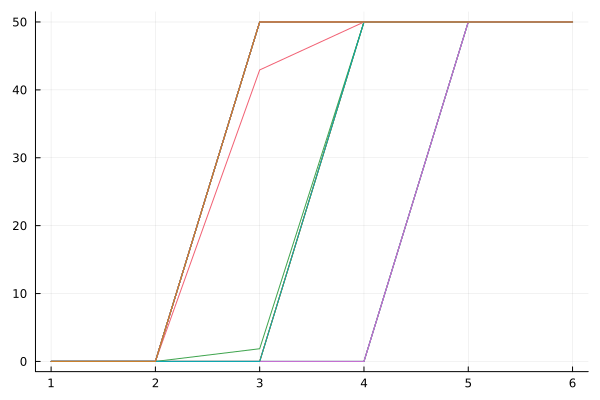

In [68]:
Plots.plot(x = 1:6, [BidCurves[t] for t in 1:T], legend = false, show=true)

#### Encapsulating nonanticipatory optimization problem 

We want to have a function that has a certain amount of input parameters, feeds them into the optimziation and returns the optimization and bidding curves.

Input:

* Producer j::Participant (from that calculate Participant O)
* Reservoir Data Array{Reservoir}
* Data of Power Plants Array{HydropowerPlant}
* Individual Reservoir Dict{Reservoir, Float64}
* Subproblem Builder ::Function
* Optimization specific Data like iterations, stages, etc.
* Reference Flow Dict{Reservoir, Float64}
* Inflow Scenario given by Water Regulation Company

Output:

* Nomination at every Reservoir Dict{Reservoir, Float64}
* Bidding Curve Dict{Int64, Array{Float64}}

The Function does the following:

1. Define the Other Participant O
2. Generate Scenarios for Prices
3. Generate Optimization Model and solve it using SDDP
4. Obtain Decision Rule and Nomination as well as Bidding Curves


In [69]:
function Nonanticipatory_Bidding(
    R::Array{Reservoir},
    j::Participant,
    subproblem_builder,
    Qinflow::Dict{Reservoir, Float64},
    PPoints::Array{Float64}
    ;

    T = 24,
    Stages = 8,
    optimizer = CPLEX.OPtimizer,
    DualityHandler = SDDP.ContinuousConicDuality()
)

    Omega = [(price = p, inflow = v) for p in Prices for v in Inflows]
    P = [1/length(Omega) for om in Omega]
    model = SDDP.LinearPolicyGraph(
        subproblem_builder;
        stages = Stages,
        sense = :Max,
        upper_bound = 1e5,
        optimizer = CPLEX.Optimizer
    )

    SDDP.train(model5; iteration_limit=10, duality_handler = DualityHandler)

    rule5 = SDDP.DecisionRule(model5; node = 1)
    solution5 = SDDP.evaluate(
        rule5;
        incoming_state = Dict(Symbol("l[$(r.dischargepoint)]") => r.currentvolume for r in R),
        controls_to_record = [:l, :x, :Qnom],
    )
    
    sol = 
    Qnom, BiddingCurves = _collect_solution(sol)
    return Qnom, BiddingCurves
end

Nonanticipatory_Bidding (generic function with 1 method)